## PSF quantification script

<details>
  <summary>>>Click to expand</summary>
    
Written by Nicholas Sofroniew, modified by Adam Glaser & Kevin Bishop

This script computes the average PSF size from a volume of diffraction limited beads for the purposes of characterizing microscope resolution.

Usage: A relatively small (~1mm^3 or less) data volume should be collected, ensuring SBR is moderately high (50 - 100x). The volume should be fused as a TIFF stack (16 bit, no downsampling, one channel per stack) sliced along the XY (highest resolution) plane. To achieve this, open the hdf5 dataset in BigStitcher, *Multiview > right-click > Interactively reorient sample...* Press *shift + Y* to orient the sample view in the XY (highest resolution) plane and click *Apply tranformation*. Define a bounding box (to fuse a subvolume if the dataset is large) and fuse to a compressed TIFF stack. Finally open the TIFF stack in FIJI (import as virtual stack for faster loading). Confirm that each single image shows the XY plane - the PSF should look circular and symmetric, not stretched. Click *Image > properties* and note the pixel sampling (width / height / depth; should all be the same) to input below.

Note: the script may take several hours to run (particularly the 'getting centers | Smoothing...' step)
    
**Note on colormaps**

Heatmaps are colored using the [vik colormap](https://www.fabiocrameri.ch/colourmaps/) by Fabio Crameri, available as a python package via pip: ```pip install cmcrameri```. This is scientific colormap which is perceptually uniform and ordered, and is color-vision-deficiency friendly. The colormap is diverging and centered about the median PSF size. In other words, red colors indicate PSFs *larger* than the median while blue colors indicate PSFs *smaller* than the median, with color intensity indicating how far the value is from the median.



## Setup environment

In [9]:
import os
import numpy as np
import json
from skimage.io import imread
from skimage.io import imsave
import pandas
import warnings
import time

from psf import compute

import plotting.plotting as psf_plot

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Optional, uncomment to use color maps from Fabio Crameri:
# https://doi.org/10.5281/zenodo.1243862
#from cmcrameri import cm




## Define plotting style

In [10]:
# run this line regardless to reset any prior styles
plt.style.use('default')


# To plot with a specific style, run one of the lines below or define a new style:
# run this line for inline display
plt.style.use('./styles/display.mplstyle')

# run this line to save for paper display
#plt.style.use('./styles/nat_prot_heat.mplstyle')

## Define parameters

In [6]:
sampling = 0.2454022 # um/px - see instructions above
wavelength = 638.0 # nm
NA = 0.4 * 1.56 # approximate collection NA
bead_size = 0.150 # um
windowUm = [8, 4, 4] # um - generally a few times the expected resolution. Too big may slow down script, 
                     # too small may truncate PSFs.
thresh_mode = 'abs'  # 'abs': thresh is minimum raw pixel value of bead peak to be counted
                     # 'rel': thresh is minimum [bead peak] / [image max] to be counted
thresh = 150
min_dist = 5 # um, min distance between adjacent beads and between beads and volume edge to be counted
rotation = False # Allow a rotational component in the 3D Gaussian fit, e.g. to analyze systems with a
                 # titled PSF. NOTE: each bead fit is rotated independently, meaning the x/y/z axes for
                 # FWHM measurements may be different from the x/y/z axes for bead position, and that 
                 # the FWHM measurement axes may vary from bead to bead. Proceed with caution - additional
                 # analysis steps to account for rotation, not provided here, may be needed.

options = {'pxPerUmLat':1.0/sampling,
           'pxPerUmAx':1.0/sampling,
           'wavelength':wavelength,
           'NA':NA,
           'bead_size':bead_size,
           'windowUm':windowUm,
           'thresh':thresh,
           'thresh_mode':thresh_mode,
           'min_dist':round(min_dist/sampling),
           'rotation':rotation}

# tiff stack should be placed in its own directory
data_base_path = './demo'
tiff_name = 'fused_tp_0_ch_0.tif'

**Example:**


<div>
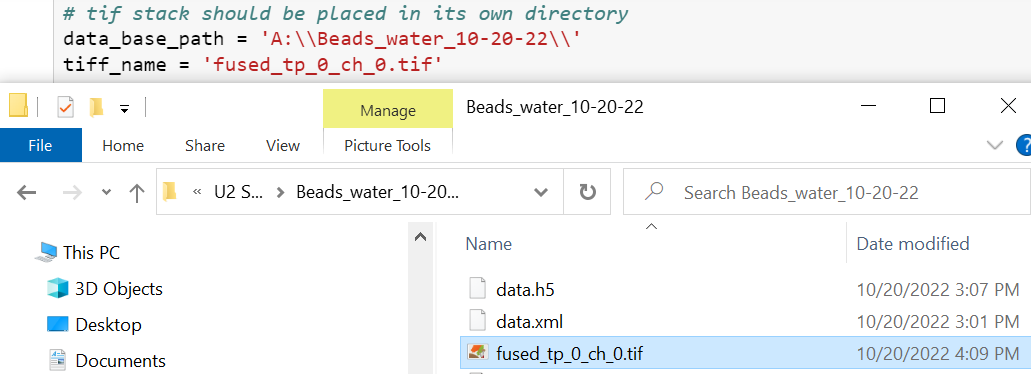
</div>

## Compute PSFs
Run this cell to generate new PSF data (may take several hours to run)

In [7]:
try: data
except NameError:
    print('Computing PSFs data')
    
    start = time.time()
    
    tiff_path = os.path.join(data_base_path,tiff_name)
    im = imread(tiff_path, plugin='tifffile')
    data, smoothed = compute(im, options)
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Execution time: {:0>2}hrs {:0>2}mins {:05.2f}secs".format(int(hours),int(minutes),seconds))
    
else: print('Error data is already defined! To recompute, delete \'data\' variable (\'del data\') and try again')


Computing PSFs data
getting centers
Smoothing...
Smoothed max:  29743.766925170792
Finding centers...
threshold_abs: 200
Found 27 beads
Keeping 23 beads
Finding maxima
got centers
Found bounds
Computing PSFs...
Found PSFs
Execution time: 00hrs 00mins 06.91secs


## Load PSF data
Run this cell to load saved PSF data (that has been previously generated by this script)

In [ ]:
try: data
except NameError:
    print('Loading data')
    data = pandas.read_csv(os.path.join(data_base_path,'PSF_data.csv'), delimiter=',')
    print('Done')
else: print('Error data is already defined! To reload, delete \'data\' variable (\'del data\') and try again')


## Plot PSF stats

### Scatterplots

<IPython.core.display.Javascript object>


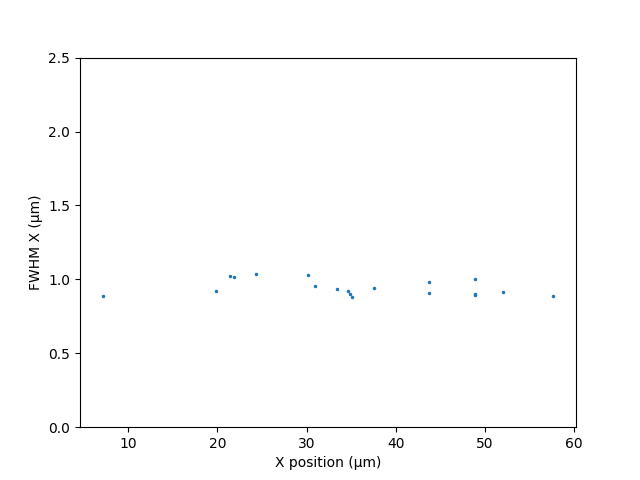

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='FWHM X (μm)'>)

In [5]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_x'
v_label = 'FWHM X (μm)'

save_name = 'x_scatter_plot.pdf'

psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      h_label=h_label,
                      v_label=v_label,
                      v_ax_lim=2.5,
                      h_ax_lims=[])

<IPython.core.display.Javascript object>


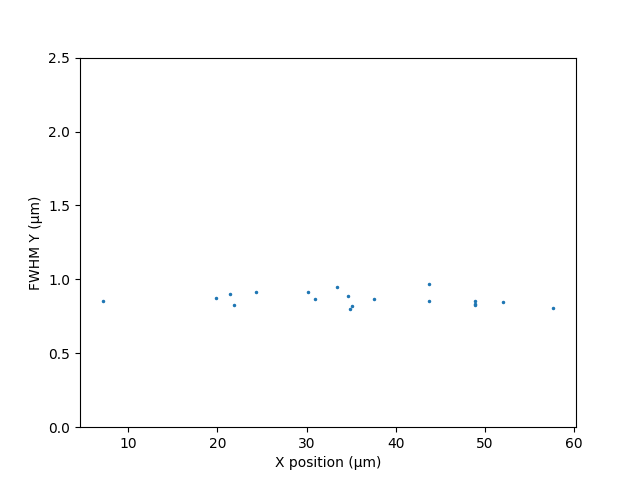

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='FWHM Y (μm)'>)

In [6]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_y'
v_label = 'FWHM Y (μm)'

save_name = 'y_scatter_plot.pdf'

psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      h_label=h_label,
                      v_label=v_label,
                      v_ax_lim=2.5,
                      h_ax_lims=[])

<IPython.core.display.Javascript object>


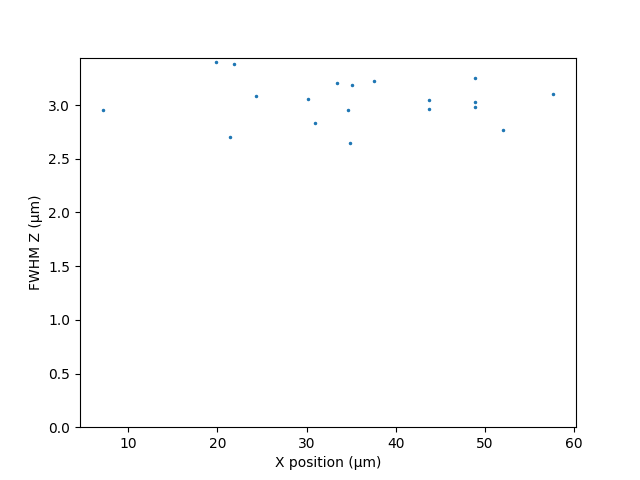

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='FWHM Z (μm)'>)

In [7]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_scatter_plot.pdf'

psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      h_label=h_label,
                      v_label=v_label,
                      v_ax_lim=[],
                      h_ax_lims=[])

C:\Users\AERB\AppData\Local\Temp\ipykernel_20940\3514909038.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_one_tile['z_center'] -= tile_min/sampling


<IPython.core.display.Javascript object>


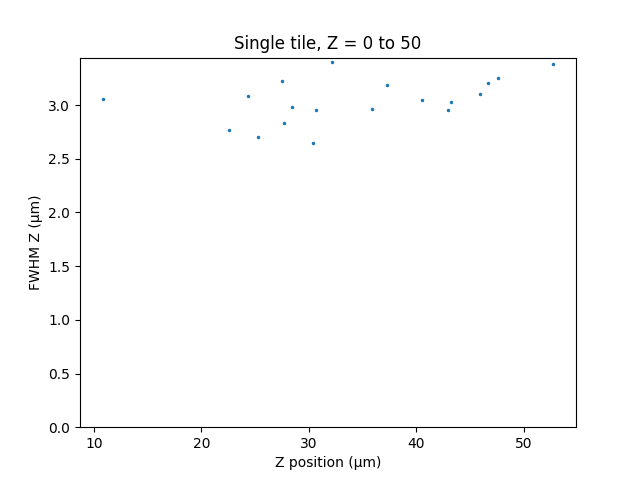

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Single tile, Z = 0 to 50'}, xlabel='Z position (μm)', ylabel='FWHM Z (μm)'>)

In [8]:
# plot only one tile
# NOTE: tile boundaries must be manually adjusted based on plot above
# multi-tile datasets may show discontinuities / artifacts at tile boundaries.
# Use this cell to manually crop data to a single tile

tile_min = 0
tile_max = 50

data_one_tile = data[(data['z_center']*sampling > tile_min) & (data['z_center']*sampling < tile_max)] 
data_one_tile['z_center'] -= tile_min/sampling

h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_scatter_plot_single_tile.pdf'
title_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)



psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      plot_title=title_string,
                      h_label=h_label,
                      v_label=v_label,
                      v_ax_lim=[],
                      h_ax_lims=[])

### Heatmaps

<IPython.core.display.Javascript object>


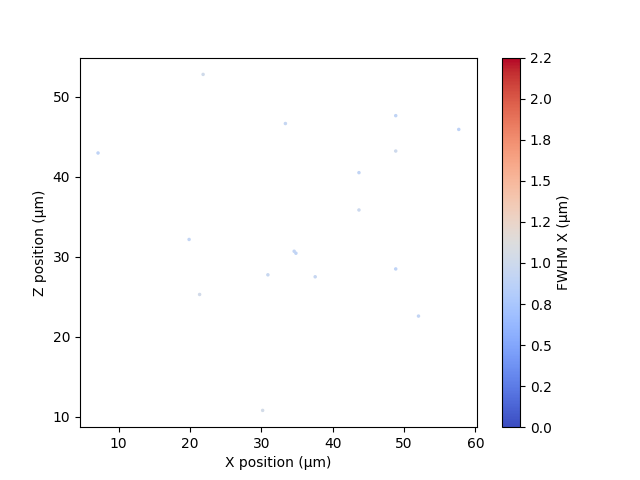

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [9]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_x'
c_label = 'FWHM X (μm)'

save_name = 'xz-x_heatmap.pdf'
psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           sampling,
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           clim=[0,2.25]
                          )


<IPython.core.display.Javascript object>


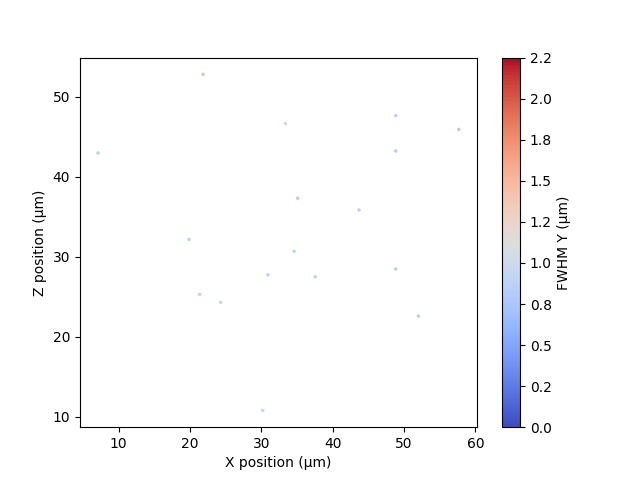

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [10]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_y'
c_label = 'FWHM Y (μm)'

save_name = 'xz-y_heatmap.pdf'
psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           sampling,
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           clim=[0,2.25]
                          )


<IPython.core.display.Javascript object>


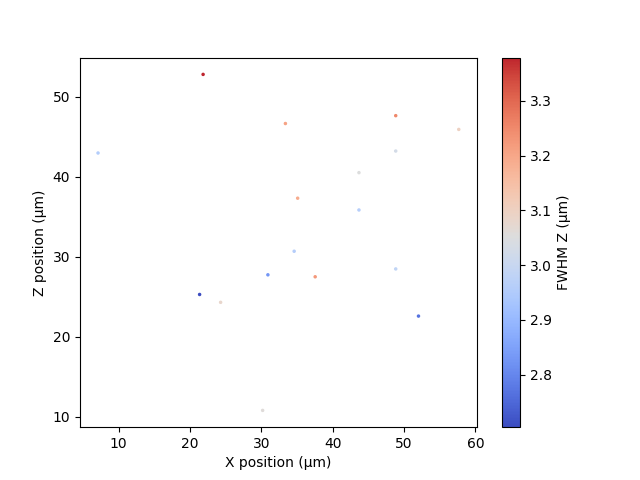

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [11]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_z'
c_label = 'FWHM Z (μm)'

save_name = 'xz-z_heatmap.pdf'

psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           sampling,
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                          )


### Histograms

<IPython.core.display.Javascript object>


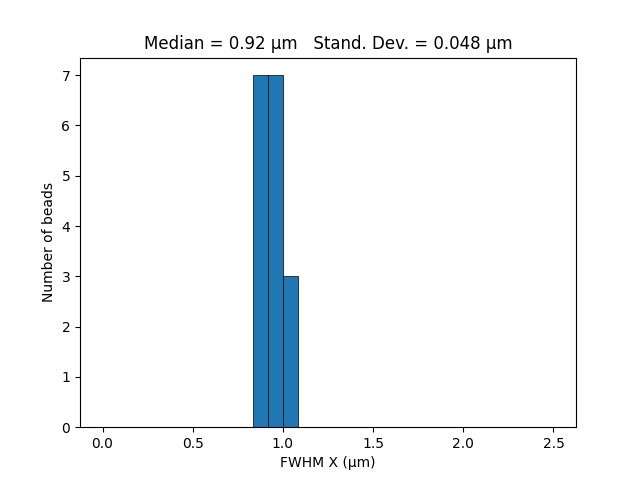

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 0.92 μm   Stand. Dev. = 0.048 μm'}, xlabel='FWHM X (μm)', ylabel='Number of beads'>)

In [12]:
h_ax = 'FWHM_x'
h_label = 'FWHM X (μm)'
v_label = 'Number of beads'
h_max_lim = 2.5
save_name = 'x_histo.pdf'

psf_plot.plot_histo(h_ax,
                    h_max_lim,
                    save_name,data_base_path,
                    data,
                    save_plot=True,
                    h_label=h_label,
                    v_label=v_label
                   )

<IPython.core.display.Javascript object>


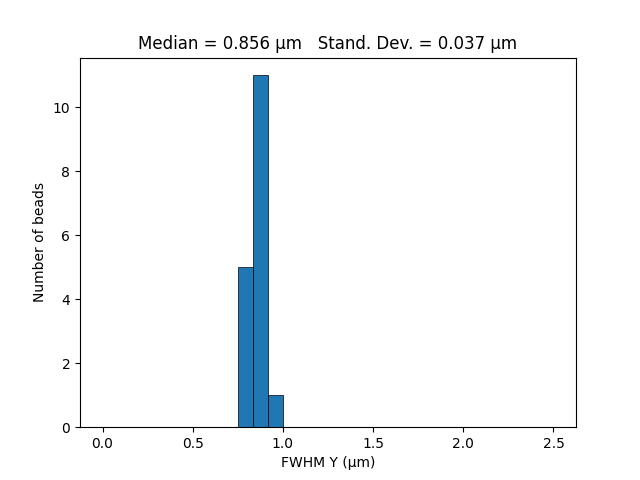

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 0.856 μm   Stand. Dev. = 0.037 μm'}, xlabel='FWHM Y (μm)', ylabel='Number of beads'>)

In [13]:
h_ax = 'FWHM_y'
h_label = 'FWHM Y (μm)'
v_label = 'Number of beads'
h_max_lim = 2.5
save_name = 'y_histo.pdf'

psf_plot.plot_histo(h_ax,
                    h_max_lim,
                    save_name,data_base_path,
                    data,
                    save_plot=True,
                    h_label=h_label,
                    v_label=v_label
                   )

<IPython.core.display.Javascript object>


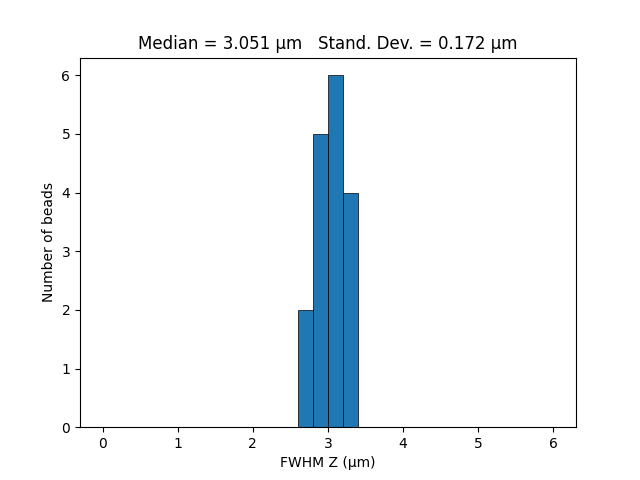

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 3.051 μm   Stand. Dev. = 0.172 μm'}, xlabel='FWHM Z (μm)', ylabel='Number of beads'>)

In [14]:
h_ax = 'FWHM_z'
h_label = 'FWHM Z (μm)'
v_label = 'Number of beads'
h_max_lim = 6.0
save_name = 'z_histo.pdf'

psf_plot.plot_histo(h_ax,
                    h_max_lim,
                    save_name,data_base_path,
                    data,
                    save_plot=True,
                    h_label=h_label,
                    v_label=v_label
                   )

In [ ]:
# Plot rotation histograms (see note on rotation parameter above)
# Note that demo data does not include rotation, so this cell will not work

if 'rotx' in data.columns:
    plt.subplots()
    plt.hist(data['rotx'],bins=20,fill='red',alpha=0.2)
    plt.hist(data['roty'],bins=21,fill='blue',alpha=0.2)
    plt.hist(data['rotz'],bins=22,fill='green',alpha=0.2)
else:
    raise Exception('No rotation in this dataset')


## Plot average Gaussian fit
This plot is a 2D slices of the average 3D Gaussian curve fit to the beads. Because this is computed analytically from the average fit parameters, the plot can be smoothed for any plot size. The plot will always be symmetric along the horizontal axis and along the vertical axis (even if the average PSF is not).

<IPython.core.display.Javascript object>


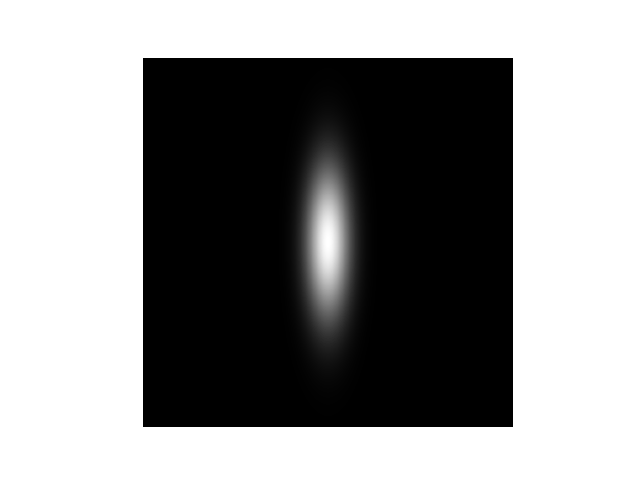

Saving plot
./demo\avg_fit_yz.tif
DONE


(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [15]:
# 0 for x, 1 for y, 2 for z
h_ax = 1 # horizontal dimension
v_ax = 2 # vertical dimension
save_name = 'avg_fit_yz.tif'

psf_plot.plot_avg_fit(h_ax=h_ax,
                      v_ax=v_ax,
                      save_name=save_name,
                      data_base_path=data_base_path,
                      data_in=data,
                      save_plot=True
                     )


***
***
*The rest of the script cannot be run with loaded (previously computed) data as the complete PSFs are not stored. To run the below sections, the PSFs must be recomputed from the raw data (above)*

## Save raw data

In [16]:
save_path = os.path.join(data_base_path, 'PSF_data.csv')
if not os.path.exists(save_path):
    data.to_csv(os.path.join(data_base_path, 'PSF_data.csv'))
else:
    raise Exception('File already exists')

## Plot average PSFs (slices)
Use caution when interpreting average PSFs - some aberrations will distort the PSFs in opposite ways at each side of the field of view, etc. For instance, if a PSF stretches to have an upward tail at the left side of the FOV and a downward tail at the right side of the FOV, the average PSF would still look symmetric (as these distortions would cancel each other out).

(66, 32, 32)


<IPython.core.display.Javascript object>


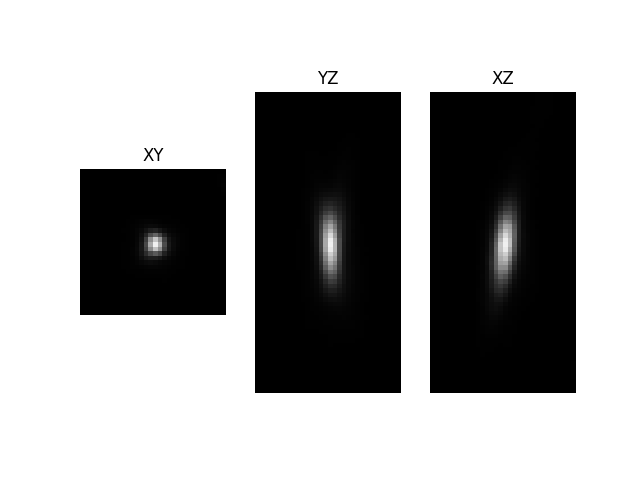

Text(0.5, 1.0, 'XZ')

In [17]:
average_psf = np.zeros(data['bead'][0].shape)
for i in range (data['bead'].shape[0]):
    average_psf = average_psf + data['bead'][i]

average_psf = average_psf/data['bead'].shape
print(average_psf.shape)
fig, axs = plt.subplots(1,3)

XY = average_psf[int(average_psf.shape[0]/2),:,:]
YZ = average_psf[:,int(average_psf.shape[1]/2),:]
XZ = average_psf[:,:,int(average_psf.shape[2]/2)]

axs[0].imshow(XY, vmin = 0, vmax = 1, cmap='gray');
axs[0].axis('off');
axs[0].set_title('XY')

axs[1].imshow(YZ, vmin = 0, vmax = 1, cmap='gray');
axs[1].axis('off');
axs[1].set_title('YZ')

axs[2].imshow(XZ, vmin = 0, vmax = 1, cmap='gray');
axs[2].axis('off');
axs[2].set_title('XZ')



In [18]:
save_path = os.path.join(data_base_path, 'XZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'YZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(YZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'XY.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XY*255).astype('uint8'))
else:
    raise Exception('File already exists')

## Plot average PSFs (projections)

<IPython.core.display.Javascript object>


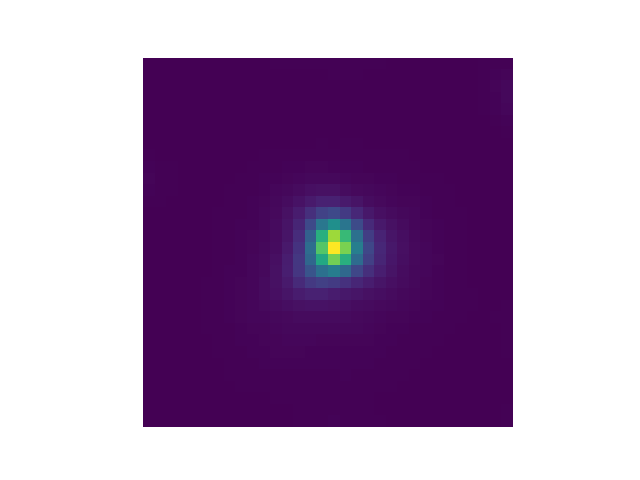

In [19]:
plt.subplots()
plt.imshow(average_psf.mean(axis=0));
plt.axis('off');

<IPython.core.display.Javascript object>


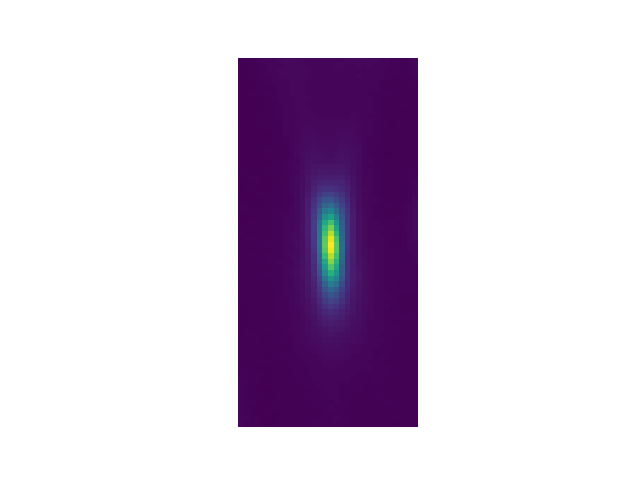

In [20]:
plt.subplots()
plt.imshow(average_psf.mean(axis=1), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

<IPython.core.display.Javascript object>


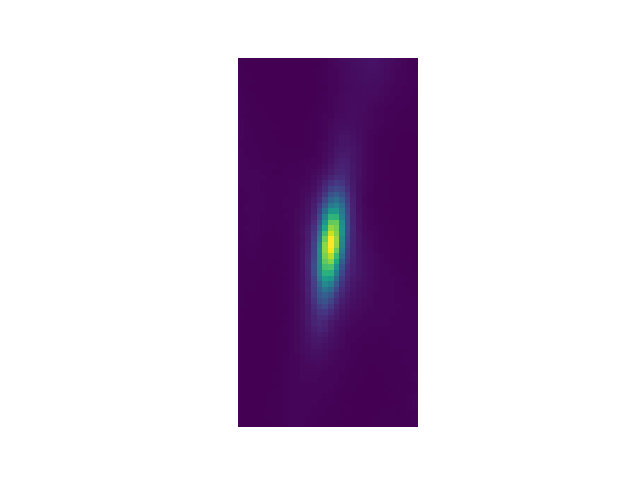

In [21]:
plt.subplots()
plt.imshow(average_psf.mean(axis=2), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

## Plot max projection of bead locations

<IPython.core.display.Javascript object>


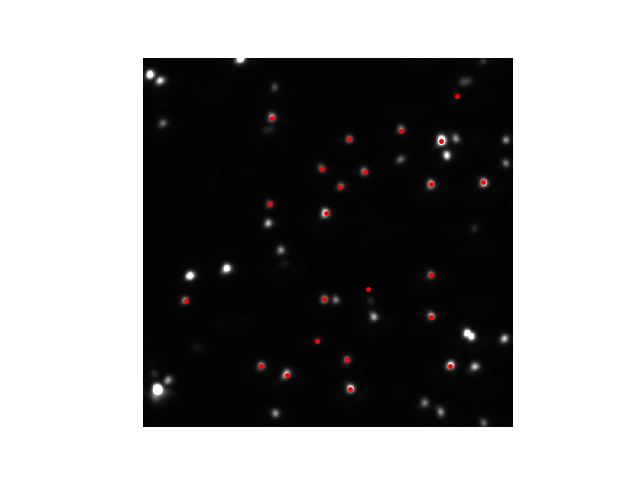

In [8]:
plt.subplots()
plt.imshow(smoothed.max(0), vmin = 0, vmax = 10000, cmap='gray');
plt.plot(data['x_center'], data['y_center'], 'r.', ms=5);

# uncomment below to zoom in on plot
# plt.xlim([0, 0+smoothed.shape[0]/4])
# plt.ylim([smoothed.shape[1]/4, 500])
plt.axis('off');